# Capstone Week 6
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
    - [Regression](#Regression)
        - [Make Function to output deciles](#Make-Function-to-output-deciles)
    - [Classification](#Classification)
        - [Balance the data with `imbalanced-learn`](#Balance-the-data-with-imbalanced-learn)
- [Scratch Work](#Scratch-Work)
    - [Feature Engineering](#Feature-Engineering)
        - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
    - [Residuals](#Residuals)
    - [Model Interpretation](#Model-Interpretation)
    - [Condition number](#Condition-number)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("../Transaction Data.xlsx", sheet_name="Transactions18")
df19 = pd.read_excel("../Transaction Data.xlsx", sheet_name="Transactions19")

## Merge 2018 and 2019

In [3]:
df = pd.merge(
    df18, 
    df19, 
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
print(df.shape)

(10005, 41)


In [4]:
df.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,sales_12M_2019,new_Fund_added_12M_2019,refresh_date_2019
0,0047433,21.0,38.0,NaN,1.0,5.0,5.0,NaN,1.0,2.0,2.0,NaN,1.0,8.0,1.0,237480.11,250.0,19682.0,-1496.745,-102496.165,NaN,-47342.32,284737.93,84.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122866.04,114614.07,0.0,0.0,2018-12-31,18633.105,NaN,2019-12-31
1,4461312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,19629.00,NaN,NaN,NaN,NaN,NaN,0.00,19629.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19629.00,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
2,4491079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1758.70,NaN,NaN,NaN,NaN,NaN,0.00,1758.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1758.70,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31
3,0107408,20.0,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,57943.00,5459.0,52484.0,NaN,NaN,1.0,0.00,0.00,57943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57943.00,0.00,0.0,0.0,2018-12-31,93212.000,1.0,2019-12-31
4,85101140503769936458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8573.59,NaN,NaN,NaN,NaN,NaN,-8573.59,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8573.59,0.00,0.0,0.0,2018-12-31,NaN,NaN,2019-12-31


## Make advisor dictionary mapper

In [5]:
adviser_lookup = {idx: contact_id for idx, contact_id in enumerate(df['CONTACT_ID'])}

In [6]:
adviser_lookup[123]

'85201142414218755394'

[Back to Top](#Index)
# Data Cleaning

In [7]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID', 
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT'
]

In [8]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [9]:
y_reg.isnull().value_counts()

False    5074
True     4931
Name: sales_12M_2019, dtype: int64

In [10]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=24, stratify=y_reg.isnull())
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

In [11]:
y_train_reg.isnull().value_counts(normalize=True)

False    0.50713
True     0.49287
Name: sales_12M_2019, dtype: float64

In [12]:
y_test_reg.isnull().value_counts(normalize=True)

False    0.507194
True     0.492806
Name: sales_12M_2019, dtype: float64

## Custom Cleaning Functions

In [13]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()

def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    elif isinstance(df, type(pd.DataFrame())):
        num_df = df.select_dtypes(include=['number']).fillna(0)
        non_num_df = df.select_dtypes(exclude=['number'])
        return pd.concat([num_df, non_num_df], axis=1)
    else:
        return np.nan_to_num(df)

def negative_to_zero(series):
    '''fill negative values to zero'''
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series
    
def bin_y_class(series):
    series = series.apply(lambda x: 1 if x >=1 else 0)
    return series

[Back to Top](#Index)
## Create Cleaning Pipeline

Convert functions to transformers

In [14]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)
bin_y_class_trans = FunctionTransformer(bin_y_class)

Make pipeline for target variables

In [15]:
reg_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero', negative_to_zero_trans),
])

class_targ_pipe = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('bin_y_class_trans', bin_y_class_trans),
])

Fit and transform TRAINING

In [16]:
y_train_reg = reg_targ_pipe.fit_transform(y_train_reg)
y_train_cl = class_targ_pipe.fit_transform(y_train_cl)

Transform only TESTING

In [17]:
y_test_reg = reg_targ_pipe.transform(y_test_reg) 
y_test_cl = class_targ_pipe.transform(y_test_cl)

In [18]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

Make pipeline for features

In [19]:
X_train.head()

,CONTACT_ID,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,refresh_date_2018,refresh_date_2019
3016,10761190984309697901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31,2019-12-31
2569,0041111,12.0,2.0,NaN,1.0,1.0,2.0,NaN,1.0,1.0,1.0,NaN,1.0,6.0,5.0,3.795556e+05,NaN,16836.479175,-10575.9,-23998.869873,1.0,2.316456e+05,79576.588224,16836.479175,0.0,37171.885,14325.0,0.0,0.0,0.0,0.0,14325.0,0.0,-1.422221e+04,372973.15,0.0,6479.645304,2018-12-31,2019-12-31
2189,85101153244714763889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31,2019-12-31
1166,4339054,4.0,7.0,2.0,3.0,2.0,4.0,1.0,2.0,2.0,2.0,1.0,2.0,9.0,2.0,-1.119938e+06,NaN,303342.790000,NaN,-366493.380000,NaN,-1.504295e+06,377202.510000,7154.470000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.211478e+06,-2331416.86,0.0,0.000000,2018-12-31,2019-12-31
959,10751192894621910308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31,2019-12-31


In [20]:
ss = StandardScaler()
ss.fit_transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0), y_train_reg)

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [21]:
ss.transform(X_train[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.08388081, -0.09275606],
       [-0.19627782, -0.10194059],
       ...,
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.10194059],
       [-0.19627782, -0.09275606]])

In [22]:
ss.transform(X_test[['no_of_sales_12M_1', 'no_of_Redemption_12M_1']].fillna(0))

array([[-0.19627782, -0.10194059],
       [-0.17754498, -0.10194059],
       [-0.19627782, -0.10194059],
       ...,
       [ 0.97452437,  1.2711469 ],
       [-0.05578155,  0.13226497],
       [-0.19627782, -0.08357153]])

In [23]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

# fit and transform TRAINING
train_array = feat_pipe.fit(X_train, y_train_reg).transform(X_train)

# Give training data row and column labels back
X_train_prepared = pd.DataFrame(
    train_array,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

In [24]:
X_train_prepared.head(2)

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
3016,-0.196278,-0.101941,-0.213159,-0.202310,-0.568538,-0.626347,-0.431731,-0.451524,-0.784367,-0.870084,-0.539912,-0.566298,-0.688081,-0.887018,-0.103503,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.020322,-0.090999,-0.046796,-0.012455,-0.027474,-0.044623,-0.029518,-0.039159,-0.082041,-0.025459,-0.084761,-0.01501,-0.065685,-0.074575,-0.018967,-0.069496
2569,-0.083881,-0.092756,-0.213159,-0.092965,-0.152531,0.181888,-0.431731,0.284471,0.213785,0.088964,-0.539912,0.770265,1.221427,3.897522,0.005228,-0.087693,-0.143764,0.041500,0.123349,0.418829,0.151346,-0.064646,-0.018608,-0.012455,0.109718,0.455268,-0.029518,-0.039159,-0.082041,-0.025459,-0.043016,-0.01501,-0.070373,0.157046,-0.018967,0.002049


**TRANSFORM** the test set (Do NOT fit the pipeline on testing!)

In [25]:
X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [26]:
X_test_prepared.head(2)

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
6307,-0.196278,-0.101941,-0.213159,-0.20231,-0.568538,-0.626347,-0.431731,-0.451524,-0.784367,-0.870084,-0.539912,-0.566298,-0.688081,-0.887018,-2.342891,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.024431,-2.677914,-0.046796,-0.012455,-0.027474,-0.044623,-0.029518,-0.039159,-0.082041,-0.025459,-0.084761,-0.01501,-0.073010,-4.915368,-0.018967,-0.069496
4521,-0.177545,-0.101941,-0.213159,-0.20231,-0.152531,-0.626347,-0.431731,-0.451524,0.213785,-0.870084,-0.539912,-0.566298,-0.369830,0.069890,-0.098414,-0.087693,-0.157788,0.090594,0.151819,-0.412074,-0.020511,-0.090999,-0.016625,-0.012455,-0.027474,-0.044623,-0.029518,-0.039159,-0.082041,-0.025459,-0.084761,-0.01501,-0.059829,-0.074575,-0.018967,-0.069496


[Back to Top](#Index)
# Model building

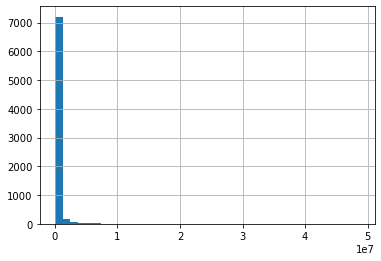

In [27]:
y_train_reg.hist(bins=40);

In [28]:
np.exp(np.log(y_train_reg+1))

3016    3.792141e+06
2569    5.656395e+05
2189    5.481558e+04
1166    7.762502e+05
959     1.000000e+00
            ...     
719     1.000000e+00
3975    2.223641e+06
9721    1.000000e+00
7684    8.350100e+04
1604    1.375100e+04
Name: sales_12M_2019, Length: 7503, dtype: float64

In [29]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

In [30]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

In [31]:
def modified_log(x):
    x = np.where(x<0, 0, x)
    return np.log(x, where=x>0)

In [32]:
def modified_exp(x):
    x = np.where(x>15, 15, x)
    return np.expm1(x)

In [33]:
# ttr = TransformedTargetRegressor(
#         RidgeCV(), 
#         func=modified_log, 
#         inverse_func=modified_exp, 
#         check_inverse=False
# )

In [34]:
ttr = TransformedTargetRegressor(
        RidgeCV(), 
        func=np.log1p, 
        inverse_func=modified_exp, 
        check_inverse=False
)

In [35]:
ttr.fit(X_train_prepared, y_train_reg)

TransformedTargetRegressor(check_inverse=False, func=<ufunc 'log1p'>,
                           inverse_func=<function modified_exp at 0x12e65fe50>,
                           regressor=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

[Back to Top](#Index)
# Make predictions

## Regression

In [36]:
test_preds = pd.Series(ttr.predict(X_test_prepared), index=y_test_reg.index)
test_preds

6307         3.064226
4521        97.427806
7859        12.029382
110          8.572280
4238        22.707121
            ...      
5710       292.812887
6026        79.301902
6246    782764.457229
8059     32928.482550
6438        31.448920
Length: 2502, dtype: float64

In [37]:
ttr.score(X_test_prepared, y_test_reg)

0.034779944502079885

[Back to Top](#Index)
### Make Function to output deciles

In [39]:
def output_deciles(model, X, y):
    results = pd.DataFrame(model.predict(X), index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results.sort_values(by='prediction', ascending=False)

In [40]:
result_df = output_deciles(ttr, X_test_prepared, y_test_reg)
result_df

,prediction,actual,deciles,contact_id
6552,3.269016e+06,4.799405e+06,9,4458879
6436,3.269016e+06,2.563772e+04,9,4332201
1822,3.269016e+06,2.730628e+06,9,4468583
1511,3.269016e+06,5.033330e+05,9,0134746
2020,3.269016e+06,1.249126e+06,9,4357691
...,...,...,...,...
3037,5.778728e+00,0.000000e+00,0,4372593
28,5.397108e+00,0.000000e+00,0,4371164
8713,3.133218e+00,0.000000e+00,0,0286901
6307,3.064226e+00,0.000000e+00,0,4495550


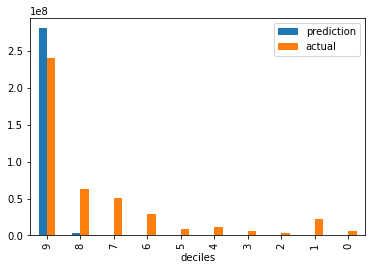

In [41]:
result_df.drop(columns='contact_id').groupby('deciles').sum().sort_index(ascending=False).plot(kind='bar');

[Back to Top](#Index)
## Classification

In [42]:
y_train_cl.value_counts()

0    5623
1    1880
Name: new_Fund_added_12M_2019, dtype: int64

In [43]:
y_test_cl.value_counts()

0    1861
1     641
Name: new_Fund_added_12M_2019, dtype: int64

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
gbt_base = GradientBoostingClassifier()
gbt_base.fit(X_train_prepared, y_train_cl)
test_pred_class = gbt_base.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1861
           1       0.52      0.10      0.17       641

    accuracy                           0.75      2502
   macro avg       0.64      0.54      0.51      2502
weighted avg       0.70      0.75      0.68      2502



In [46]:
def output_deciles_class(model, X, y):
    results = pd.DataFrame(model.predict_proba(X)[:,1], index=y.index, columns=['prediction'])
    results['actual'] = y.values
    results['deciles'] = pd.qcut(results['prediction'], 10, labels=False)
    results['contact_id'] = results.index.map(adviser_lookup)
    return results.sort_values(by='prediction', ascending=False)

In [47]:
output_deciles_class(gbt_base, X_train_prepared, y_train_cl)

,prediction,actual,deciles,contact_id
1783,0.932667,1,9,85101103674323007541
7325,0.914916,1,9,4417770
7629,0.914758,1,9,0215284
6867,0.914558,1,9,0232384
5035,0.899724,1,9,4316840
...,...,...,...,...
7905,0.071795,0,0,0035524
5275,0.071207,0,0,0298171
9418,0.069437,0,0,4484142
974,0.067010,0,0,0025009


### Balance the data with `imbalanced-learn`

In [48]:
from imblearn.over_sampling import SMOTE

In [49]:
X_train_prepared.head(2)

,no_of_sales_12M_1,no_of_Redemption_12M_1,no_of_sales_12M_10K,no_of_Redemption_12M_10K,no_of_funds_sold_12M_1,no_of_funds_redeemed_12M_1,no_of_fund_sales_12M_10K,no_of_funds_Redemption_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_redeemed_12M_1,no_of_assetclass_sales_12M_10K,no_of_assetclass_Redemption_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M_2018,redemption_curr,redemption_12M,new_Fund_added_12M_2018,aum_AC_EQUITY,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MONEY,aum_AC_MULTIPLE,aum_AC_PHYSICAL_COMMODITY,aum_AC_REAL_ESTATE,aum_AC_TARGET,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT
3016,-0.196278,-0.101941,-0.213159,-0.202310,-0.568538,-0.626347,-0.431731,-0.451524,-0.784367,-0.870084,-0.539912,-0.566298,-0.688081,-0.887018,-0.103503,-0.087693,-0.158849,0.090594,0.151819,-0.412074,-0.020322,-0.090999,-0.046796,-0.012455,-0.027474,-0.044623,-0.029518,-0.039159,-0.082041,-0.025459,-0.084761,-0.01501,-0.065685,-0.074575,-0.018967,-0.069496
2569,-0.083881,-0.092756,-0.213159,-0.092965,-0.152531,0.181888,-0.431731,0.284471,0.213785,0.088964,-0.539912,0.770265,1.221427,3.897522,0.005228,-0.087693,-0.143764,0.041500,0.123349,0.418829,0.151346,-0.064646,-0.018608,-0.012455,0.109718,0.455268,-0.029518,-0.039159,-0.082041,-0.025459,-0.043016,-0.01501,-0.070373,0.157046,-0.018967,0.002049


In [50]:
y_train_cl.value_counts()

0    5623
1    1880
Name: new_Fund_added_12M_2019, dtype: int64

In [51]:
# instantiate SMOTENC
smote = SMOTE(random_state=0)

# balance data
X_smote, y_smote = smote.fit_resample(X_train_prepared, y_train_cl)

In [52]:
y_smote.value_counts()

1    5623
0    5623
Name: new_Fund_added_12M_2019, dtype: int64

In [53]:
gbt_base2 = GradientBoostingClassifier()
gbt_base2.fit(X_smote, y_smote)
test_pred_class2 = gbt_base2.predict(X_test_prepared)
print(classification_report(y_test_cl, test_pred_class2))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1861
           1       0.46      0.54      0.50       641

    accuracy                           0.72      2502
   macro avg       0.65      0.66      0.65      2502
weighted avg       0.74      0.72      0.73      2502



# Scratch Work

[Back to Top](#Index)
## Lift Chart Evaluation

In [ ]:
# conda install -yc conda-forge scikit-plot

In [ ]:
import scikitplot as skplt

In [ ]:
test_pred_proba = gbt_base2.predict_proba(X_test_prepared)

In [ ]:
skplt.metrics.plot_lift_curve(y_test_cl, test_pred_proba);

[Back to Top](#Index)
## Cross Validation

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
-cross_validate(feat_pipe, X_train_prepared, y_train_reg, scoring='neg_root_mean_squared_error')['test_score']

In [ ]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = np.exp(model.predict(X))
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, 10000], [0, 10000])
    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

In [ ]:
evaluate_model(feat_pipe, X_train_prepared, y_train_reg)

In [ ]:
y_train_reg_log = np.log(y_train_reg+1)
y_test_reg_log = np.log(y_test_reg+1)

In [ ]:
feat_pipe.fit(X_train_prepared, y_train_reg_log)

In [ ]:
feat_pipe.predict(X_test_prepared)[0]

In [ ]:
np.exp(1.5966611)

In [ ]:
evaluate_model(feat_pipe, X_train, y_train_reg_log)

In [ ]:
evaluate_model(feat_pipe, X_test, y_test_reg_log)

[Back to Top](#Index)
## Feature Engineering

**What is feature engineering**?

"Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." - Andrew Ng

Feature engineering is the term broadly applied to the creation and manipulation of features (variables) used in machine learning algorithms. Unless we're working with the same data over and over again, this isn't something we can automate. It will require creativity and a good, thorough understanding of our data.

Regression results can change significantly depending on feature selection. Let's take a closer look at our features.

In [ ]:
X_train_prepared.corr().style.background_gradient().set_precision(2)

In [ ]:
X_train_prepared.hist(bins=40, figsize=(16,10));

[Back to Top](#Index)
### Variable Inflation Factor (VIF)

VIF measures the amount of multicollinearity in a set of multiple regressors, by evaluating how much the variance of the independent variable is inflated by it's interaction with other independent variables. VIF threshold of 5 to 10 are acceptable, but values above 10 are too high.  

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
funds = pd.concat([X_train_prepared, y_train_reg.to_frame()], axis=1)
features = funds.columns.tolist()
target = 'sales_12M_2019'

In [ ]:
transformer = ReduceVIF()

X_tr_vif = transformer.fit_transform(X_train_prepared, y_train_reg)
X_tr_vif.head()

[Back to Top](#Index)
## Residuals

In [ ]:
y_test_preds = feat_pipe.predict(X_test_prepared)

In [ ]:
# get residuals
residuals = y_test_preds - y_test_reg

In [ ]:
# plot predictions vs residuals
fig, axes = plt.subplots(2,2,figsize=(14,10))

# plot scatter on upper right plot
axes[0,0].scatter(x=y_test_preds, y=residuals, alpha=0.5)
axes[0,0].set(xlabel="Residuals",ylabel="Predictions");

# plot hist on upper left plot
axes[0,1].hist(residuals, bins=50)
axes[0,1].set(xlabel='Residuals', ylabel='Frequency');

In [ ]:
from statsmodels.api import qqplot

In [ ]:
axes[1,0].set_ylim([-3.5, 3.5])
axes[1,0].set_xlim([-3.5, 3.5])

In [ ]:
qqplot(residuals, fit=True, line='r', ax=axes[1,0])

[Back to Top](#Index)
## Model Interpretation

[Back to Top](#Index)
## Condition number

Numerical analysis has a notion of condition number, which measures how sensitive a function is to changes in the input, and how much error in the output results from an error in the input. In linear regression this number can be used to diagnose multicollinearity. 

In [ ]:
from numpy import linalg as LA
from itertools import chain, combinations

# Find all possible combinations of any length more than 2
def all_subsets(set_arg):
    return chain(*map(lambda x: combinations(set_arg, x), range(2, len(set_arg)+1)))

funds = pd.concat([X_train_prepared, y_train_reg.to_frame()], axis=1)
features = funds.columns.tolist() 
target = 'sales_12M_2019'

cond_nums = {}
for subset in all_subsets(features):
    # checking that target varaible is included in the matrix
    if target not in list(subset):
        continue
    cond_nums[', '.join(list(subset))] = LA.cond(funds[list(subset)])
    
sorted(cond_nums.items(), key=lambda x:x[1])